In [0]:
!chmod +x get_data.sh
!./get_data.sh

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.models.unet import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
import re
from fastai.callbacks import Hooks
from fastai.callbacks.hooks import *

# 1. Getting the paths of the images

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [3]:
paths = getListOfFiles('data/news')

In [4]:
videos = []
for path in paths:
    videos.append(re.findall(r'.*/(.*)/.*',path)[0])

videos = list(set(videos))
videos

['news']

# 2. Creating the Datasets, Dataloaders and Databunch

In [5]:
class CustomDataset(Dataset):
    def __init__(self,paths,n_ref=1,block_size=(240,240),tfms = None,valid=False,valid_pct=0.2):
        self.paths = paths
        self.n_ref = n_ref
        self.block_size = block_size
        self.videos = None
        self.spaths = []
        self.tfms = tfms
        self.valid = valid
        self.valid_pct = valid_pct
        self.update_params()
        
    def update_params(self):
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        self.videos = list(set(videos))
        
        df = pd.DataFrame(zip(videos,paths),columns=['video','path'])
        
        for video in self.videos:
            #import pdb;pdb.set_trace()
            aux = list(df.loc[df.video==video]['path'])
            aux.sort(key=lambda f:int(re.sub('\D','',f)))
            nframes = len(aux)
            if not self.valid: self.spaths.extend(aux[:int(nframes*(1-self.valid_pct))])
            if self.valid: self.spaths.extend(aux[-int(nframes*(self.valid_pct)):])

    def __len__(self): return len(self.spaths) - self.n_ref - len(self.videos)
    
    def check(self,idx):
        paths = self.spaths[idx:idx+self.n_ref+1:1]
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        if len(list(set(videos))) == 1: return True #if all frames are from the same video
        else: return False
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        is_same_video = self.check(idx)
        if not is_same_video: idx = idx+self.n_ref
            
        paths = self.spaths[idx:idx+self.n_ref+1:1] #the last one is the target
        
        frames = []
        for path in paths:
            frames.append(torch.from_numpy(io.imread(path).astype("float32").transpose(2,0,1))/255)
                
        #apply the transforms
        if self.tfms:
            norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            tfms_frames = []
            for i,frame in enumerate(frames):
                frame = fastai.vision.Image(frame)
                if i==0:
                    frame = frame.apply_tfms(self.tfms, size=self.block_size)
                else:
                    frame = frame.apply_tfms(self.tfms, size=self.block_size, do_resolve=False)
                tfms_frames.append(norm(frame.data))
            
        input,target = (torch.cat(tfms_frames[:self.n_ref]),tfms_frames[-1])
        #the target is the residual
        target = target - input[-3:] 
        return input,target
    
    def show(self,idx,figsize=(15, 15)):
        
        x,y = self.__getitem__(idx)
        imgs = []
        idx = 0
        for _ in range(int(x.shape[0]/3)): 
            imgs.append(x[idx:idx+3])
            idx+=3
        imgs.append(y)
        f, ax = plt.subplots(1,len(imgs),figsize=figsize)
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        for i,frame in enumerate(imgs):
            x = (frame.numpy().transpose((1,2,0))*stds + means)*255
            ax[i].imshow(x.astype(np.uint8),)
            if i < len(imgs)-1:
                ax[i].title.set_text('Ref Frame {}'.format(i))
            else:
                ax[i].title.set_text('Target Frame')

In [6]:
tfms = get_transforms(do_flip=False,max_rotate=2.5,max_warp=None)

In [ ]:
all_y = []
for i in range(len(train_ds)):
    _,y = train_ds[i]
    all_y.append(y.unsqueeze(0))

In [20]:
bla = torch.cat(all_y,0)

In [21]:
bla.shape

torch.Size([5730, 240, 240])

In [7]:
train_ds = CustomDataset(paths,tfms=tfms[0],valid=False,n_ref=2,block_size=(240,240))
valid_ds = CustomDataset(paths,tfms=tfms[1],valid=True,n_ref=2,block_size=(240,240))

/usr/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


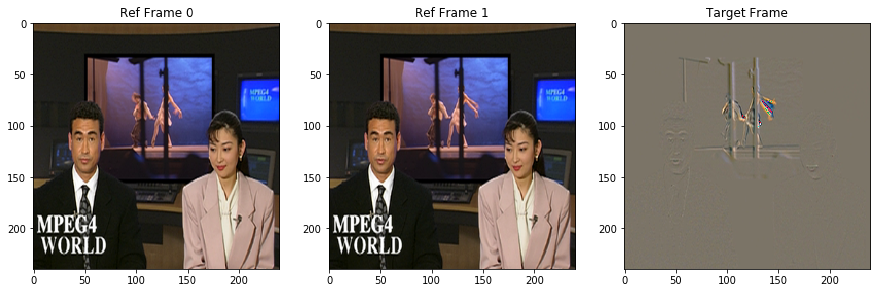

In [8]:
train_ds.show(210)

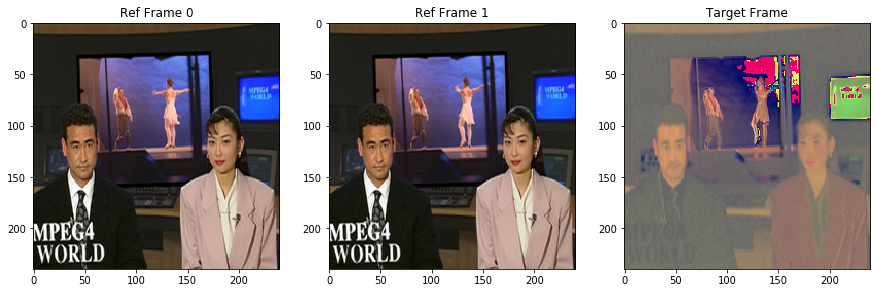

In [45]:
train_ds.show(0)

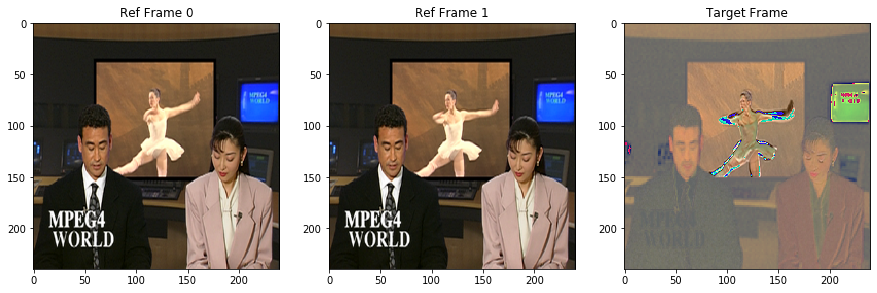

In [46]:
valid_ds.show(0)

In [47]:
len(train_ds)

1910

In [9]:
train_dl = DataLoader(train_ds,batch_size=4, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds,batch_size=4, shuffle=True, num_workers=2)

In [49]:
data = DataBunch(train_dl,valid_dl)

# 3. Creating the model

## 3.1. Defining the encoder

In [50]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
input,target = next(iter(train_dl))

In [11]:
class CNNEncoder(nn.Module):
    def __init__(self,arch):
        super(CNNEncoder,self).__init__()
        self.arch = nn.Sequential(*list(arch.children())[:-1])
    def forward(self,x):
        n = x.shape[1]//3
        out = []
        i=0
        for _ in range(n):
            out.append(self.arch(x[:,i:i+3,:,:]).squeeze().unsqueeze(0))
            i+=3
        return torch.cat(out)

In [17]:
arch = models.resnet18(pretrained=True)
cnn_encoder = CNNEncoder(arch)
lstm = nn.LSTM(input_size=512,hidden_size=512)
reshape = Lambda(lambda x: x[0][-1])
seq_encoder = nn.Sequential(cnn_encoder,lstm,reshape)

In [18]:
encoded = seq_encoder(input)

In [19]:
encoded[0].shape

torch.Size([512])

## 3.2. Putting a Unet Decoder (without skip connections) on top of the Encoder

In [56]:
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [57]:
#unet block without skip connections
class UnetBlock(Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        self.hook = hook
        self.up_in_c= up_in_c
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = (up_in_c//2)# + x_in_c)//3
        #import pdb;pdb.set_trace()
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(up_out)
        #import pdb;pdb.set_trace()
        return self.conv2(self.conv1(cat_x))

In [58]:
class DynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, cnn_encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(cnn_encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([cnn_encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(cnn_encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()


In [59]:
model = DynamicUnet(seq_encoder, cnn_encoder.arch, n_classes=3, img_size=(240,240), blur=False, blur_final=True,
        self_attention=False, y_range=None, norm_type=None, last_cross=False,
        bottle=True)

In [60]:
model(input).shape

torch.Size([4, 3, 240, 240])

# 4. Creating the Learner and Training the Model

In [0]:
learn = Learner(data,model,loss_func = nn.MSELoss(), metrics=mean_absolute_error)

#creates the layer groups
learn.split([learn.model[0][0].arch[:6],
            learn.model[0][0].arch[6:],
            learn.model[0][1],
            learn.model[1:]])


#I'll fit the lstm, the convolutional decoder and the batch norm layers on the encoder
learn.freeze_to(-2)

epoch,train_loss,valid_loss,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


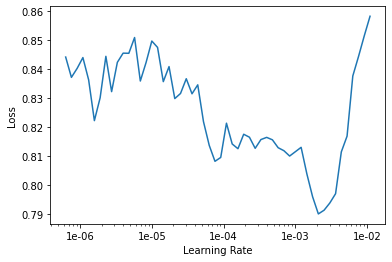

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save("stage-0")

In [0]:
learn.load("stage-0");

In [0]:
learn.fit_one_cycle(100,max_lr=1e-4,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1.1')])

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.821549,0.833383,0.709843,01:00
1,0.815471,0.927336,0.731944,01:00
2,0.817636,0.989234,0.744862,01:00
3,0.806262,0.762315,0.690535,01:00
4,0.827418,0.761672,0.688993,01:02
5,0.776136,0.901117,0.720008,01:01
6,0.768482,0.716181,0.664563,01:02
7,0.769382,0.808058,0.686273,01:01
8,0.707841,0.697982,0.650496,01:00
9,0.716501,0.725801,0.656153,01:00


Better model found at epoch 0 with valid_loss value: 0.8333829641342163.
Better model found at epoch 3 with valid_loss value: 0.7623145580291748.
Better model found at epoch 4 with valid_loss value: 0.7616716027259827.
Better model found at epoch 6 with valid_loss value: 0.7161812782287598.
Better model found at epoch 8 with valid_loss value: 0.6979822516441345.
Better model found at epoch 10 with valid_loss value: 0.6428081393241882.
Better model found at epoch 11 with valid_loss value: 0.6024335622787476.
Better model found at epoch 15 with valid_loss value: 0.6014344096183777.
Better model found at epoch 16 with valid_loss value: 0.5290511250495911.
Better model found at epoch 17 with valid_loss value: 0.5073823928833008.
Better model found at epoch 19 with valid_loss value: 0.481571763753891.
Better model found at epoch 20 with valid_loss value: 0.4791180491447449.
Better model found at epoch 21 with valid_loss value: 0.4737168550491333.
Better model found at epoch 22 with valid_lo

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
def show_results(learn,figsize=(10,10)):
    inputs,targets = next(iter(learn.data.valid_dl))
    learn.model.eval()
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0][-3:].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (targets[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = ((preds[0]+inputs[0][-3:]).cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    inp = inp.astype('uint8')
    target = target.astype('uint8')
    pred = pred.astype('uint8')
    inp = inp.astype('float32')
    target = target.astype('float32')
    pred = pred.astype('float32')

    #mse_pred = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    mse_pred = mean_squared_error(target.flatten(),pred.flatten())
    psnr_pred = 10*np.log10(255/mse_pred)

    print('MSE for pred:',mse_pred)
    print('PSNR for pred:', psnr_pred)

    #mse_inp = np.sum(((inp - target)**2))/(inp.shape[0]*inp.shape[1]*inp.shape[2])
    mse_inp = mean_squared_error(target.flatten(),inp.flatten())
    psnr_inp = 10*np.log10(255/mse_inp)

    print('MSE for input:',mse_inp)
    print('PSNR for input:',psnr_inp)

    #import pdb;pdb.set_trace()

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Last Reference')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
_ = learn.load('stage-1.1')

MSE for pred: 1123.9673
PSNR for pred: -6.442134901559498
MSE for input: 2.0444908
PSNR for input: 20.95955016801762


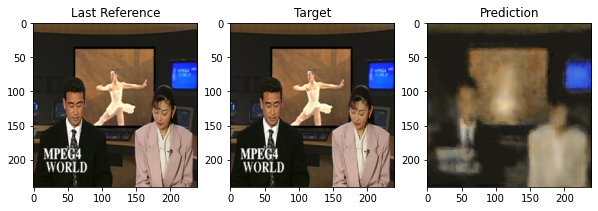

In [0]:
show_results(learn)